# Code to create figure 6
### Elbow Method

Used in the manuscript,  
Evaporative Moisture Sources of Colorado’s Front Range: A Case Study of the Exceptionally Wet May-July Season of 2023

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy.stats as stats
import numpy.ma as ma
import numpy.linalg as LA
import matplotlib as mpl
import xarray as xr
import scipy

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import glob
from scipy.cluster.vq import kmeans,vq
import cartopy as ct
import cartopy.crs as ccrs
import pandas as pd
import os
import datetime as dt
from datetime import date, timedelta, datetime
import cmocean as cmocean
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#MODIFY----
save_plots = True
sink_region_name = 'nfr'
mapProj = ccrs.LambertConformal(central_longitude=-106)
local = True
#----------
if sink_region_name == 'Eastern_CO':
    DATA_DIRECTORY = '/Volumes/LaCie_10TB_Keys_KH/era5/output/backtrack/aggregated_files/aggregated_'+sink_region_name+'_2000_2023/'
if local:
    DATA_DIRECTORY = '/Users/kathum/Research/COPEX/aggregated_files/wam_output/aggregated_co_altclimate_nfr_2000_2023/'
SAVE_DIRECTORY = '/Users/kathum/Research/COPEX/figures/2000-2023_'+sink_region_name+'/'+ datetime.today().strftime('%m_%d_%Y') +'/'
if save_plots == True:
    if not os.path.exists(SAVE_DIRECTORY):
        os.makedirs(SAVE_DIRECTORY)
        print('created new directory at: ', SAVE_DIRECTORY)

## Open data and preprocess it

In [3]:
### Modify ----------
months = [5,6,7]
exclude_2023 = False
#--------------------
#open all years from this run
da = xr.open_mfdataset(DATA_DIRECTORY+'*.nc')#['e_track']
if exclude_2023:
    da = da.sel(time = ~(da.time.dt.year == 2023)) 
#only retain months May and June
may_june = da.sel(time = da.time.dt.month.isin(months))
#Group by year and sum to get cumulative E-track across may-june
sum_may_june = may_june.resample(time = '1YE').sum()
#Turn into anomalies
data = (sum_may_june - sum_may_june.mean(dim = 'time')).e_track.values
#data = (((sum_may_june - sum_may_june.mean(dim = 'time')).e_track)/sum_may_june.std(dim='time').e_track).fillna(0).values
lat = may_june['latitude']
lon = may_june['longitude']

## Run clustering analysis
runtime on my computer: ~85 min

In [4]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = data.reshape(data.shape[0],data.shape[1]*data.shape[2])
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init=1000).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

## Visualize the results

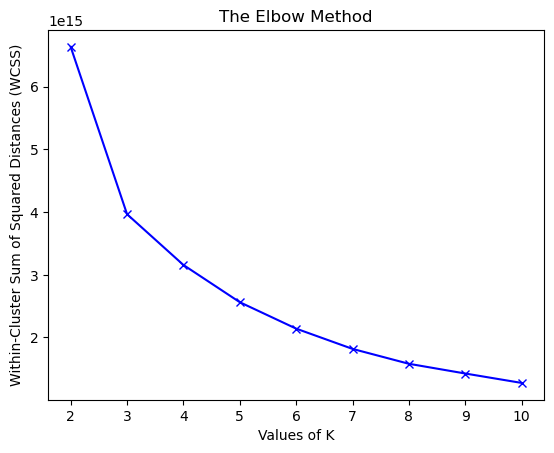

In [5]:
ax = plt.axes()
plt.plot([k+1 for k in K], inertias, 'bx-')
ax.set_xticks([k+1 for k in K]) 
plt.xlabel('Values of K')
plt.ylabel('Within-Cluster Sum of Squared Distances (WCSS)')
plt.title('The Elbow Method')
if 7 in months:
    plt.savefig(SAVE_DIRECTORY+'mjj_elbow_method.png', dpi = 400,  bbox_inches='tight')
else:
    plt.savefig(SAVE_DIRECTORY+'mj_elbow_method.png', dpi = 400,  bbox_inches='tight')

